Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=d8433d4f4703af73b23d55c0e6779626f0547d9af580341fc661bad1667cc139
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 3.9 MB/s 
     |████████████████████████████████| 163 kB 72.7 MB/s 
     |████████████████████████████████| 7.6 MB 55.8 MB/s 
[7719, 12479, 14089, 14308]
[4, 4, 4, 4]
[23510, 21452, 2199

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    valid_dataset_idxs = [i for i,labels in enumerate(labels) if tag2idx["O"] in labels]
    valid_dataset_sents = [sent for i,sent in enumerate(dataset) if i in valid_dataset_idxs]
    valid_dataset_labels = [labels for i,labels in enumerate(labels) if i in valid_dataset_idxs]

    random_idxs = np.random.choice(len(valid_dataset_sents), number_of_new_sentences, replace=True)
    base_labels = [valid_dataset_labels[i] for i in random_idxs]

    if not all([tag2idx["O"] in labels for labels in base_labels]):
        raise Exception("Sentence without 'O'-tagged token in the dataset!!!")

    base_sequences = [valid_dataset_sents[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-11-01 21:51:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-01 21:51:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-01 21:51:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10376 words (18048 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2842400   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,004,656
Trainable params: 3,004,656
Non-trainable p

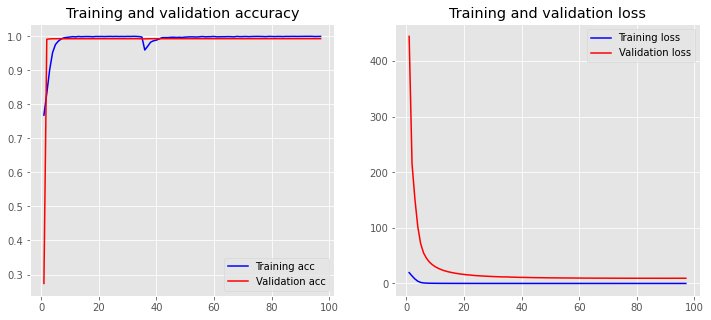

864/864 [==============================] - 61s 68ms/step
F1-score: 46.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.49482566470307277,0.4952593418851088,0.4950424083144188,12551.0
test,0.554677924553997,0.45195295162006216,0.498073983491287,9012.0
treatment,0.44165054803352677,0.3676075990125577,0.40124179943767574,9317.0
micro avg,0.4958062183658713,0.4441062176165803,0.46853433549709605,30880.0
macro avg,0.49705137909686553,0.43827329750590954,0.46478606374779385,30880.0
weighted avg,0.49624911042089564,0.4441062176165803,0.4676259666884253,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10368 words (18045 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          2841300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,003,556
Trainable params: 3,003,556
Non-trainable

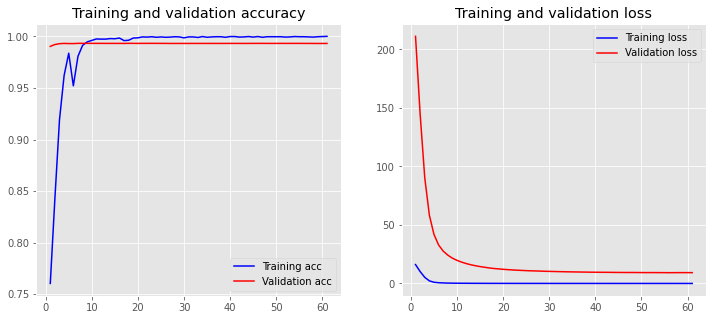

864/864 [==============================] - 62s 69ms/step
F1-score: 48.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.48774786393680475,0.4821129790454944,0.48491405216973194,12551.0
test,0.541493542953397,0.5350643586329339,0.5382597533069153,9012.0
treatment,0.47655942219304004,0.3895030589245465,0.4286557996692653,9317.0
micro avg,0.5013482679941921,0.4696243523316062,0.48496806340500953,30880.0
macro avg,0.5019336096944139,0.4688934655343249,0.4839432017153042,30880.0
weighted avg,0.5000572340006284,0.4696243523316062,0.48350839543726587,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10378 words (18043 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          2842100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,004,356
Trainable params: 3,004,356
Non-trainable

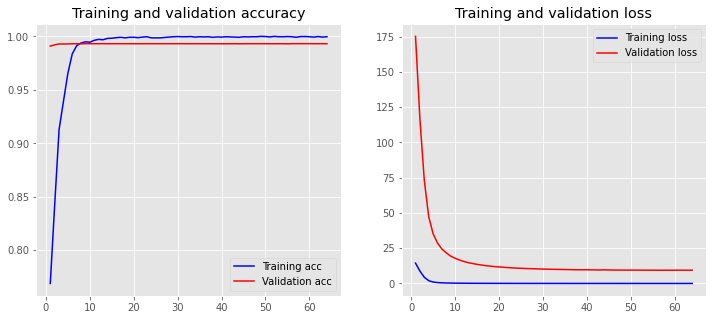

864/864 [==============================] - 63s 70ms/step
F1-score: 48.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.4598077763215378,0.5031471595888773,0.4805021875594445,12551.0
test,0.5829383886255924,0.49134487350199735,0.5332369942196532,9012.0
treatment,0.4953697304768487,0.38467317806160783,0.4330594490091832,9317.0
micro avg,0.5015578505163661,0.4639572538860104,0.48202540163176044,30880.0
macro avg,0.5127052984746597,0.45972173705082753,0.48226621026276034,30880.0
weighted avg,0.5064717596424306,0.4639572538860104,0.48157803220157586,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10367 words (18045 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          2841200   
                                                                 
 bidirectional_3 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,003,456
Trainable params: 3,003,456
Non-trainable

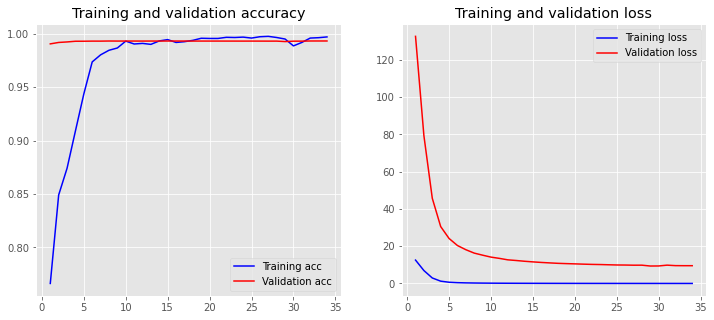

864/864 [==============================] - 63s 70ms/step
F1-score: 45.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.3436827403031552,0.5979603218867022,0.4364894730720018,12551.0
test,0.556715291750503,0.49123391034176656,0.5219287903796275,9012.0
treatment,0.4831537307325058,0.38016528925619836,0.42551657856799613,9317.0
micro avg,0.41686422413793106,0.50110103626943,0.4551176470588235,30880.0
macro avg,0.46118392092872135,0.48978650716155575,0.4613116140065418,30880.0
weighted avg,0.44793470181461115,0.50110103626943,0.4581133289490258,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10372 words (18048 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          2842000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,004,256
Trainable params: 3,004,256
Non-trainable

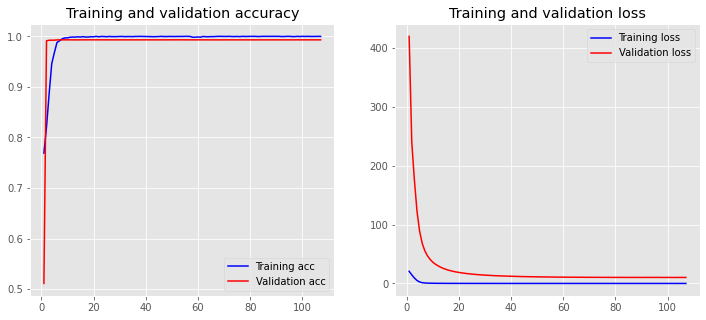

864/864 [==============================] - 63s 70ms/step
F1-score: 44.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.441458443421152,0.46593896900645365,0.4533684781766028,12551.0
test,0.5177830840769134,0.4571682201509099,0.48559137250279927,9012.0
treatment,0.4481032665964173,0.3651389932381668,0.40238926015731263,9317.0
micro avg,0.46430059730518125,0.4329663212435233,0.44808633286413296,30880.0
macro avg,0.46911493136482757,0.42941539413184343,0.44711637027890494,30880.0
weighted avg,0.46573783069814906,0.4329663212435233,0.447391125501148,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10377 words (18051 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 204, 100)          2842800   
                                                                 
 bidirectional_5 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,005,056
Trainable params: 3,005,056
Non-trainable

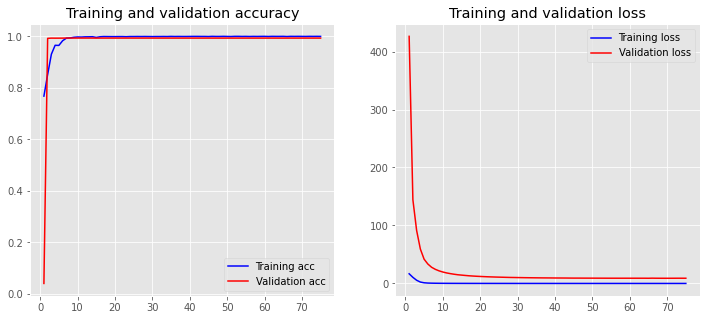

864/864 [==============================] - 62s 69ms/step
F1-score: 49.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.49522292993630573,0.49557804159031155,0.49540042212576163,12551.0
test,0.5571525577184246,0.546271637816245,0.5516584491259524,9012.0
treatment,0.49094156672620565,0.4130084791241816,0.4486155639755173,9317.0
micro avg,0.5127933228432647,0.4854598445595855,0.4987523704960575,30880.0
macro avg,0.5144390181269787,0.48495271951024604,0.49855814507574375,30880.0
weighted avg,0.5120046768451125,0.4854598445595855,0.4977029744554214,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10372 words (18044 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 204, 100)          2841600   
                                                                 
 bidirectional_6 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,003,856
Trainable params: 3,003,856
Non-trainable

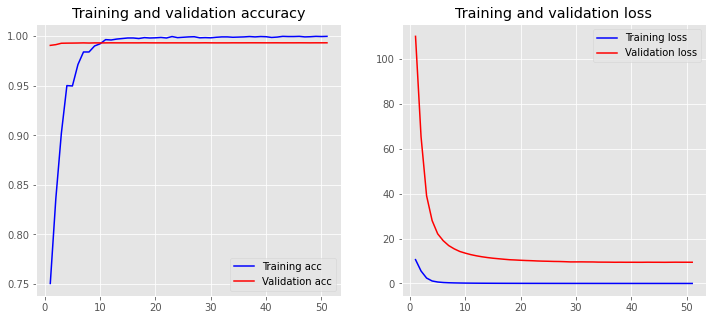

864/864 [==============================] - 64s 70ms/step
F1-score: 48.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.48617619493908154,0.495976416221815,0.4910274107671071,12551.0
test,0.5409172126265634,0.5038837106080781,0.5217441259263514,9012.0
treatment,0.5050828575407325,0.3892883975528604,0.43968965935264875,9317.0
micro avg,0.5071529245947851,0.46609455958549223,0.48575767802902464,30880.0
macro avg,0.5107254217021259,0.4630495081275845,0.48415373201536904,30880.0
weighted avg,0.507856228192293,0.46609455958549223,0.4845023203230204,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10377 words (18043 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 204, 100)          2842000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,004,256
Trainable params: 3,004,256
Non-trainable

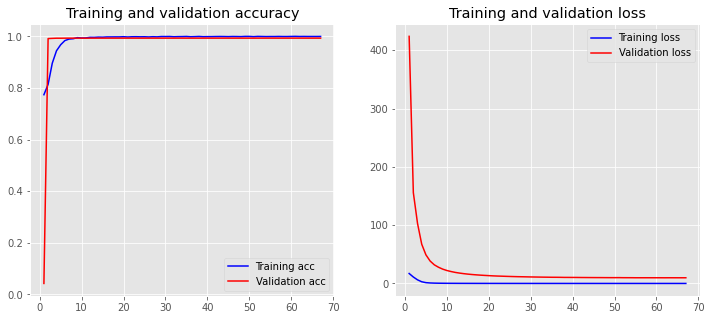

864/864 [==============================] - 63s 70ms/step
F1-score: 44.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.4530283841168144,0.4845032268345152,0.4682374682374682,12551.0
test,0.5152443083477566,0.42942743009320905,0.4684379349996974,9012.0
treatment,0.46530920060331826,0.3311151658259096,0.38690662820593213,9317.0
micro avg,0.47293571324916556,0.42215025906735754,0.44610225172815,30880.0
macro avg,0.4778606310226297,0.41501527425121126,0.4411940104810326,30880.0
weighted avg,0.47489076353307114,0.42215025906735754,0.44375713047475407,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10373 words (18055 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 204, 100)          2842800   
                                                                 
 bidirectional_8 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,005,056
Trainable params: 3,005,056
Non-trainable

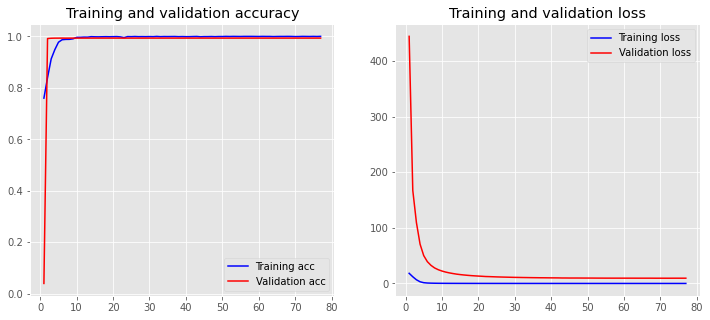

864/864 [==============================] - 63s 70ms/step
F1-score: 48.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.4567304222302418,0.5041829336307864,0.4792850109823525,12551.0
test,0.5769230769230769,0.5309587217043942,0.5529874032127585,9012.0
treatment,0.4738592523613144,0.38231190297306,0.42319116074610913,9317.0
micro avg,0.4946740376188229,0.47522668393782386,0.48475539259406075,30880.0
macro avg,0.5025042505048777,0.4724845194360802,0.48515452498040673,30880.0
weighted avg,0.49697541945896695,0.47522668393782386,0.48386984116788806,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Converted 10372 words (18047 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 204, 100)          2841900   
                                                                 
 bidirectional_9 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,004,156
Trainable params: 3,004,156
Non-trainable

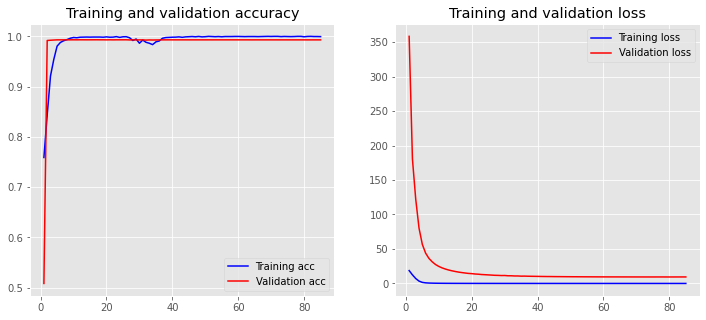

864/864 [==============================] - 63s 69ms/step
F1-score: 47.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.46572427420580637,0.4882479483706478,0.4767202147108016,12551.0
test,0.5590744570837642,0.4799156679982246,0.5164795796513016,9012.0
treatment,0.4680796071336263,0.38875174412364494,0.42474347698622106,9317.0
micro avg,0.4915828443699357,0.45579663212435234,0.4730138459470359,30880.0
macro avg,0.4976261128077322,0.4523051201641724,0.4726477571161081,30880.0
weighted avg,0.4936781759216307,0.45579663212435234,0.47264133295768856,30880.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10379 words (18055 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 204, 100)          2843400   
                                                                 
 bidirectional_10 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,005,656
Trainable params: 3,005,656
Non-trainabl

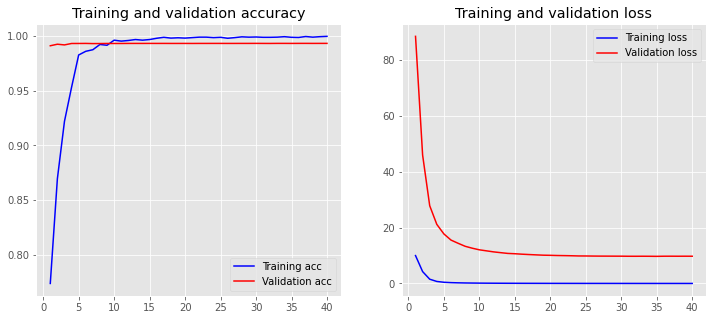

864/864 [==============================] - 63s 70ms/step
F1-score: 48.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.4876330619912336,0.4963747908533185,0.49196509653729226,12551.0
test,0.579185520361991,0.46870838881491345,0.5181232750689972,9012.0
treatment,0.49186778593913955,0.4024900719115595,0.44271294492650964,9317.0
micro avg,0.512909399487235,0.4599740932642487,0.48500162190770485,30880.0
macro avg,0.5195621227641214,0.4558577505265971,0.48426710551093305,30880.0
weighted avg,0.5156293598493912,0.4599740932642487,0.484738905098499,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10377 words (18055 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 204, 100)          2843200   
                                                                 
 bidirectional_11 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,005,456
Trainable params: 3,005,456
Non-trainabl

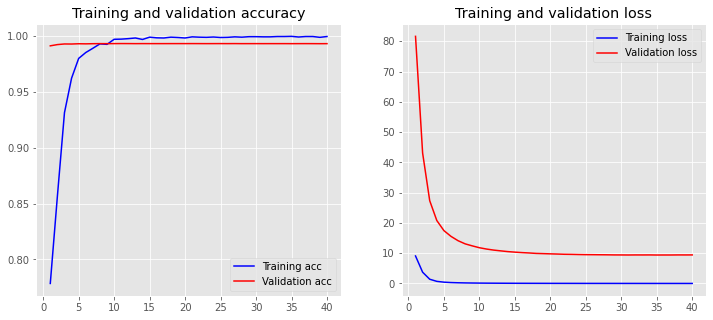

864/864 [==============================] - 63s 70ms/step
F1-score: 49.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.49409875551987154,0.49031949645446576,0.4922018715508278,12551.0
test,0.5609697838289741,0.5211939636040834,0.5403508771929824,9012.0
treatment,0.4964656964656965,0.38445851668992165,0.43334139849987907,9317.0
micro avg,0.5146738936633027,0.467389896373057,0.4898935899394124,30880.0
macro avg,0.5171780786048474,0.4653239922494903,0.4886313824145631,30880.0
weighted avg,0.5143284995585335,0.467389896373057,0.48849448202464274,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10389 words (18060 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 204, 100)          2844900   
                                                                 
 bidirectional_12 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,007,156
Trainable params: 3,007,156
Non-trainabl

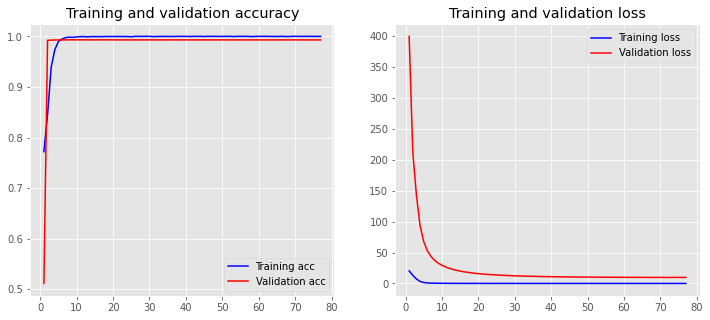

864/864 [==============================] - 63s 69ms/step
F1-score: 45.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.45623553817920687,0.45558122858736355,0.4559081486206346,12551.0
test,0.5299408575653031,0.4772525521526853,0.502218589444185,9012.0
treatment,0.4411764705882353,0.3461414618439412,0.38792325735249894,9317.0
micro avg,0.47369362280482136,0.4288860103626943,0.4501776032903346,30880.0
macro avg,0.4757842887775818,0.42632508086133,0.4486833318057728,30880.0
weighted avg,0.473202086286798,0.4288860103626943,0.44891120758296027,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10394 words (18058 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 204, 100)          2845200   
                                                                 
 bidirectional_13 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,007,456
Trainable params: 3,007,456
Non-trainabl

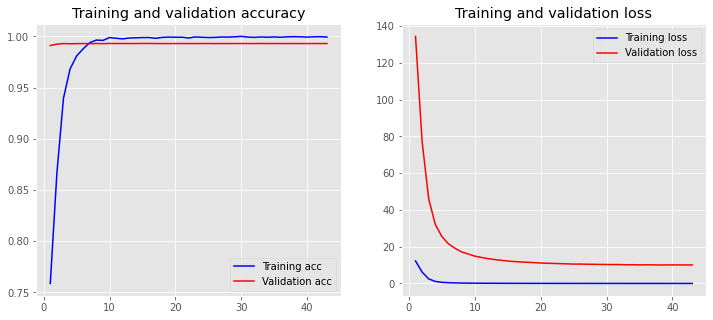

864/864 [==============================] - 62s 69ms/step
F1-score: 46.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.4555564196282759,0.4667357182694606,0.4610783156237702,12551.0
test,0.5590412849792947,0.494340878828229,0.5247040810317413,9012.0
treatment,0.45339308578745197,0.3800579585703553,0.4134991533835465,9317.0
micro avg,0.4837628326000419,0.448639896373057,0.4655398366880607,30880.0
macro avg,0.4893302634650076,0.4470448518893482,0.4664271833463527,30880.0
weighted avg,0.48510466526132073,0.448639896373057,0.465291409641402,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10384 words (18046 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 204, 100)          2843000   
                                                                 
 bidirectional_14 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,005,256
Trainable params: 3,005,256
Non-trainabl

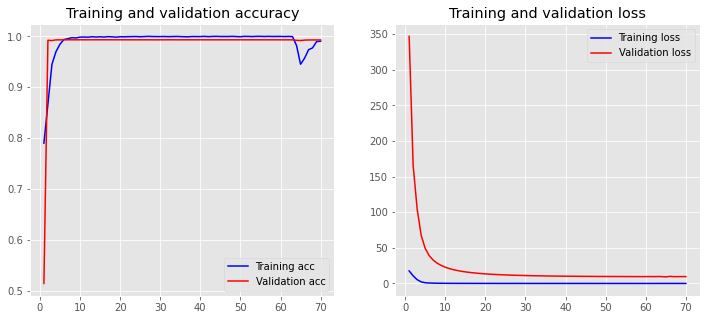

864/864 [==============================] - 62s 69ms/step
F1-score: 41.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.33012144936264176,0.5241016652059597,0.40508667672506693,12551.0
test,0.43897678241216354,0.47414558366622284,0.4558839219033394,9012.0
treatment,0.4383808095952024,0.3138349254051733,0.3657972102333146,9317.0
micro avg,0.37916322598403523,0.44608160621761656,0.40990923969647375,30880.0
macro avg,0.4024930137900025,0.43736072475911864,0.408922602953907,30880.0
weighted avg,0.3945533379872874,0.44608160621761656,0.4080570398806024,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10382 words (18051 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 204, 100)          2843300   
                                                                 
 bidirectional_15 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,005,556
Trainable params: 3,005,556
Non-trainabl

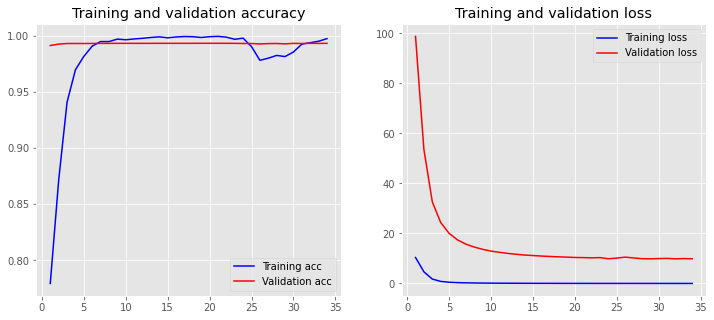

864/864 [==============================] - 63s 70ms/step
F1-score: 46.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.48358554535681797,0.46593896900645365,0.47459827950008115,12551.0
test,0.4931394394277002,0.46660008877052817,0.479502822281772,9012.0
treatment,0.4474066892874455,0.39626489213266075,0.42028573054812457,9317.0
micro avg,0.4760667775006927,0.44511010362694303,0.46006828223323065,30880.0
macro avg,0.47471055802398787,0.4429346499698809,0.45812894410999255,30880.0
weighted avg,0.47545799650216924,0.44511010362694303,0.45964263574889,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10378 words (18059 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 204, 100)          2843700   
                                                                 
 bidirectional_16 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,005,956
Trainable params: 3,005,956
Non-trainabl

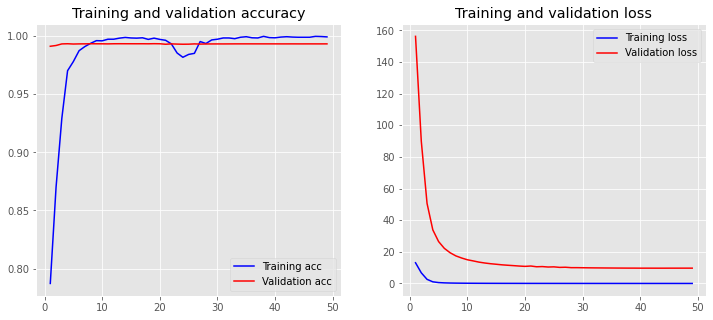

864/864 [==============================] - 63s 69ms/step
F1-score: 48.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.47535423575520047,0.5025097601784718,0.48855494016034695,12551.0
test,0.5443841625303013,0.5233022636484687,0.5336350777934936,9012.0
treatment,0.48115239633817986,0.383599871203177,0.4268736936398925,9317.0
micro avg,0.4971899587860622,0.47270077720207254,0.48463619914009193,30880.0
macro avg,0.5002969315412272,0.4698039650100392,0.483021237197911,30880.0
weighted avg,0.4972492863461599,0.47270077720207254,0.48310086070823693,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10386 words (18053 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 204, 100)          2843900   
                                                                 
 bidirectional_17 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,006,156
Trainable params: 3,006,156
Non-trainabl

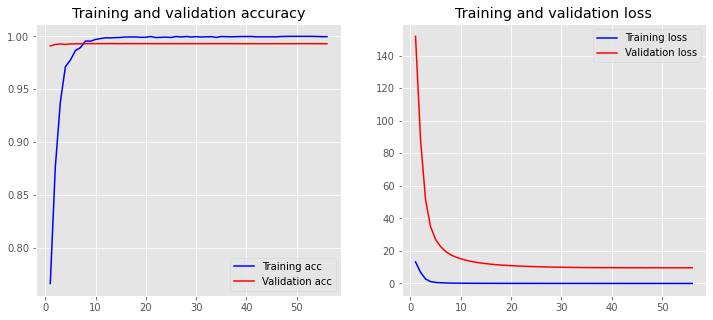

864/864 [==============================] - 63s 70ms/step
F1-score: 47.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.4595238095238095,0.47669508405704725,0.467951976848774,12551.0
test,0.5677943876212955,0.4804704837993786,0.5204952518331529,9012.0
treatment,0.47212671905697445,0.41268648706665234,0.44041005669778366,9317.0
micro avg,0.4917679749913164,0.4584844559585492,0.47454332160214513,30880.0
macro avg,0.49981497206735986,0.4566173516410261,0.47628576179323684,30880.0
weighted avg,0.4949239312185971,0.4584844559585492,0.47497632672288176,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10389 words (18054 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 204, 100)          2844300   
                                                                 
 bidirectional_18 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,006,556
Trainable params: 3,006,556
Non-trainabl

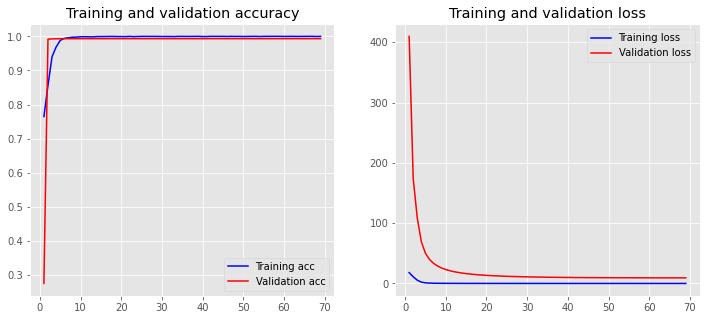

864/864 [==============================] - 63s 70ms/step
F1-score: 47.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.477504873294347,0.48792924866544496,0.48266078184110967,12551.0
test,0.5431341268867346,0.4911229471815357,0.5158207563661791,9012.0
treatment,0.4844077751363446,0.3717934957604379,0.4206946805926645,9317.0
micro avg,0.4982755555555556,0.45382124352331604,0.47501059232268456,30880.0
macro avg,0.5016822584391419,0.45028189720247286,0.4730587395999844,30880.0
weighted avg,0.4987407920066685,0.45382124352331604,0.4736419840784207,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Converted 10376 words (18051 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 204, 100)          2842700   
                                                                 
 bidirectional_19 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,004,956
Trainable params: 3,004,956
Non-trainabl

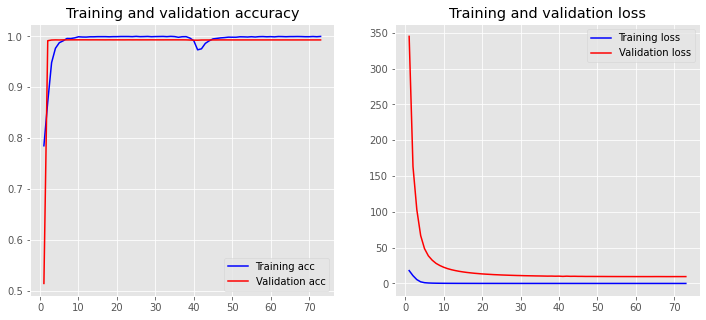

864/864 [==============================] - 64s 70ms/step
F1-score: 46.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.4952959786862043,0.4739861365628237,0.4844068072632522,12551.0
test,0.5517895878524945,0.4516200621393697,0.4967049060288015,9012.0
treatment,0.4714387974230494,0.3534399484812708,0.4039995092626672,9317.0
micro avg,0.5047777946306689,0.4310880829015544,0.46503178928247046,30880.0
macro avg,0.5061747879872495,0.4263487157278214,0.4617037408515736,30880.0
weighted avg,0.5045849374937753,0.4310880829015544,0.46373568260663567,30880.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10384 words (18070 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 204, 100)          2845400   
                                                                 
 bidirectional_20 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,007,656
Trainable params: 3,007,656
Non-trainabl

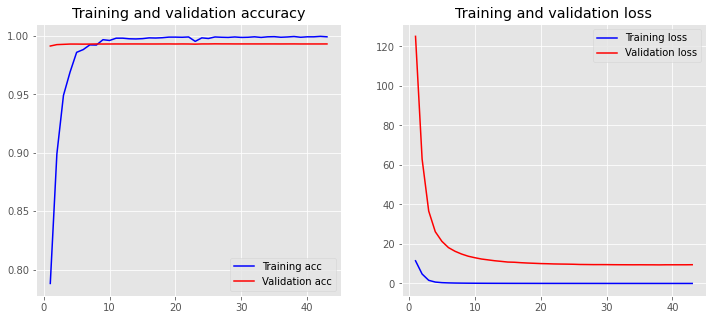

864/864 [==============================] - 62s 68ms/step
F1-score: 48.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.498984482898692,0.4893633973388575,0.4941271118262269,12551.0
test,0.5835733066232628,0.5171992898357746,0.5483851991293606,9012.0
treatment,0.4729299363057325,0.3825265643447462,0.4229514033109833,9317.0
micro avg,0.5162043690715723,0.4652525906735751,0.48940591361220875,30880.0
macro avg,0.5184959086092291,0.4630297505064594,0.48848790475552356,30880.0
weighted avg,0.5158097506706877,0.4652525906735751,0.4884868853540545,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10388 words (18060 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 204, 100)          2844800   
                                                                 
 bidirectional_21 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,007,056
Trainable params: 3,007,056
Non-trainabl

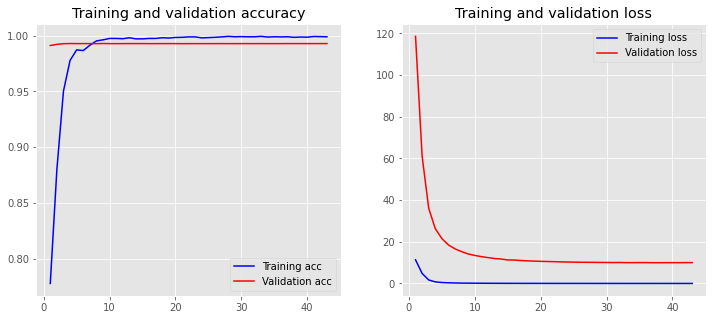

864/864 [==============================] - 63s 69ms/step
F1-score: 46.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.46904800387910134,0.46243327224922315,0.4657171514543631,12551.0
test,0.5496432458580239,0.5043275632490013,0.5260112262021874,9012.0
treatment,0.4891664158892567,0.34893205967586133,0.407316920378375,9317.0
micro avg,0.49836930631389936,0.44041450777202074,0.46760301879007715,30880.0
macro avg,0.5026192218754607,0.43856429839136196,0.4663484326783085,30880.0
weighted avg,0.49863892244816443,0.44041450777202074,0.46569303386020544,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10400 words (18067 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 204, 100)          2846700   
                                                                 
 bidirectional_22 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,008,956
Trainable params: 3,008,956
Non-trainabl

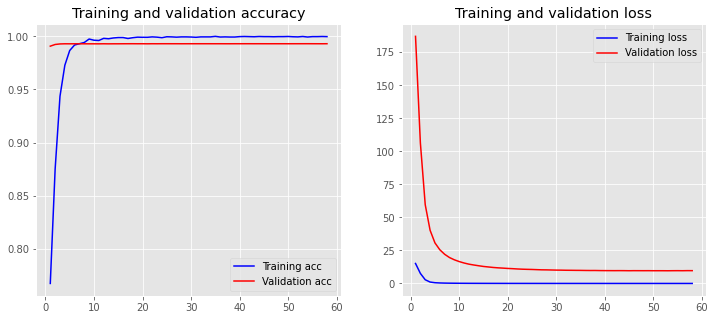

864/864 [==============================] - 63s 69ms/step
F1-score: 45.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.4614033748186608,0.48147557963508886,0.47122582657517154,12551.0
test,0.49913901963035245,0.48246782068353306,0.4906618518309541,9012.0
treatment,0.43459069020866775,0.34871739830417514,0.3869469421782885,9317.0
micro avg,0.46578336292856165,0.4417098445595855,0.45342729871684057,30880.0
macro avg,0.46504436155256035,0.4375535995409323,0.4496115401948047,30880.0
weighted avg,0.46432629737473785,0.4417098445595855,0.45146970914250817,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10397 words (18060 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 204, 100)          2845700   
                                                                 
 bidirectional_23 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,007,956
Trainable params: 3,007,956
Non-trainabl

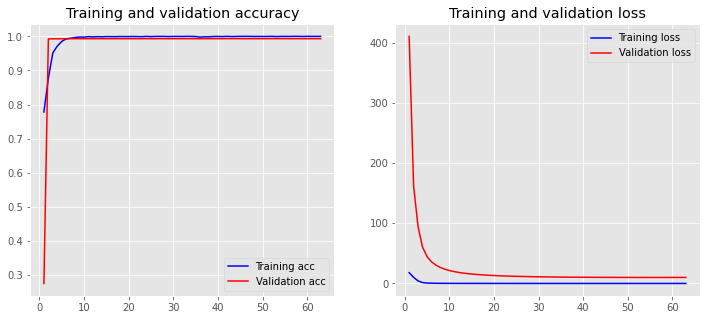

864/864 [==============================] - 64s 70ms/step
F1-score: 46.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.4551454224541478,0.4725519878894112,0.4636854037995466,12551.0
test,0.5644516612540594,0.5014425210830005,0.5310847338112588,9012.0
treatment,0.46673095467695275,0.36363636363636365,0.40878378378378377,9317.0
micro avg,0.48904438789934973,0.4481217616580311,0.4676896038934703,30880.0
macro avg,0.49544267946171994,0.44587695753625844,0.4678513071315297,30880.0
weighted avg,0.4905408313849987,0.4481217616580311,0.4667904675423798,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10389 words (18059 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 204, 100)          2844800   
                                                                 
 bidirectional_24 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,007,056
Trainable params: 3,007,056
Non-trainabl

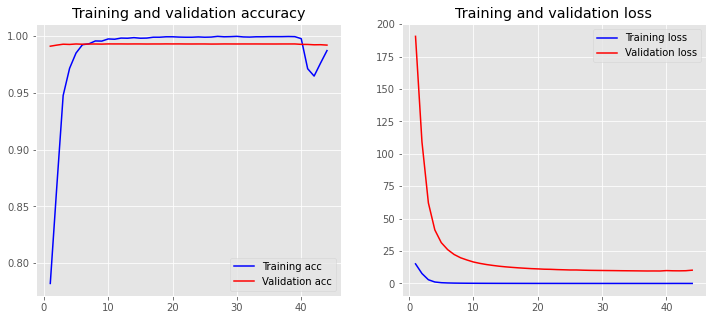

864/864 [==============================] - 63s 70ms/step
F1-score: 46.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.480083857442348,0.4743845111943271,0.4772171682763595,12551.0
test,0.534975857372787,0.4794718153573014,0.5057054245421031,9012.0
treatment,0.44164699711513244,0.361489749919502,0.39756831729917963,9317.0
micro avg,0.4854296388542964,0.4418069948186529,0.4625921844536747,30880.0
macro avg,0.48556890397675584,0.43844869215704346,0.46016363670588073,30880.0
weighted avg,0.48450647647422784,0.4418069948186529,0.4614998049639404,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10390 words (18069 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 204, 100)          2845900   
                                                                 
 bidirectional_25 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,008,156
Trainable params: 3,008,156
Non-trainabl

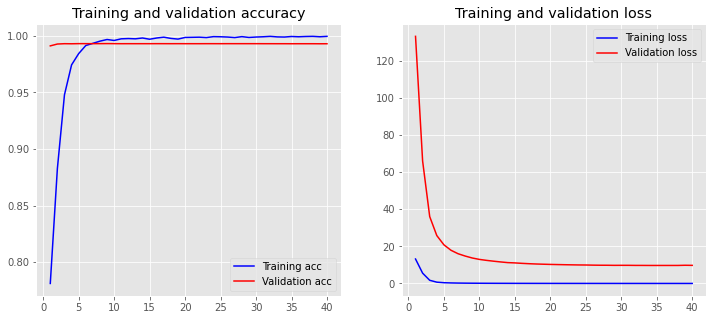

864/864 [==============================] - 63s 69ms/step
F1-score: 46.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.47294798617252193,0.46872759142697795,0.47082833133253305,12551.0
test,0.5175856065002902,0.49478473146915225,0.5059284052873433,9012.0
treatment,0.46719870147436765,0.3707201889020071,0.4134051466187911,9317.0
micro avg,0.48497205329208704,0.4467616580310881,0.46508335159370945,30880.0
macro avg,0.4859107647157266,0.4447441705993791,0.4633872944128892,30880.0
weighted avg,0.48424034850610814,0.4467616580310881,0.4637464030457072,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10395 words (18063 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 204, 100)          2845800   
                                                                 
 bidirectional_26 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,008,056
Trainable params: 3,008,056
Non-trainabl

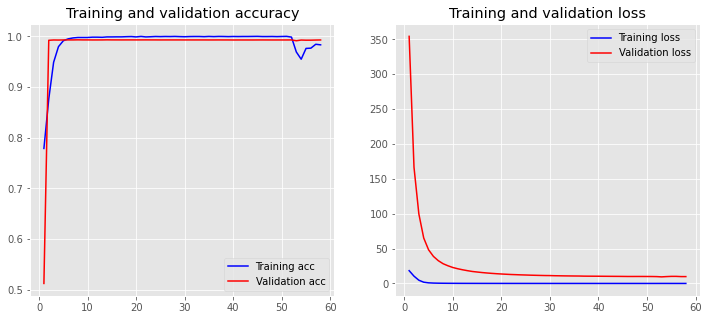

864/864 [==============================] - 63s 69ms/step
F1-score: 39.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.2941734224624283,0.4943829176958011,0.368862204256331,12551.0
test,0.5594370860927153,0.3749445184198846,0.4489768801488174,9012.0
treatment,0.41011505273250237,0.36728560695502843,0.3875205254515599,9317.0
micro avg,0.36660371508301154,0.42117875647668396,0.39200084392000845,30880.0
macro avg,0.42124185376254863,0.4122043476902381,0.4017865366189028,30880.0
weighted avg,0.4065692872895794,0.42117875647668396,0.3978723414881651,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10404 words (18067 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 204, 100)          2847100   
                                                                 
 bidirectional_27 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,009,356
Trainable params: 3,009,356
Non-trainabl

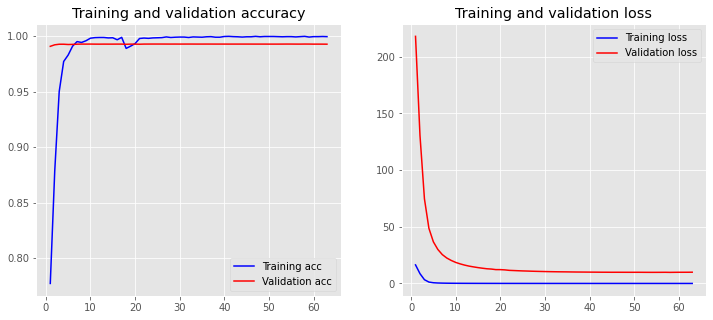

864/864 [==============================] - 63s 70ms/step
F1-score: 45.6%


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10382 words (18064 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2844600   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,006,856
Trainable params: 3,006,856
Non-trainable p

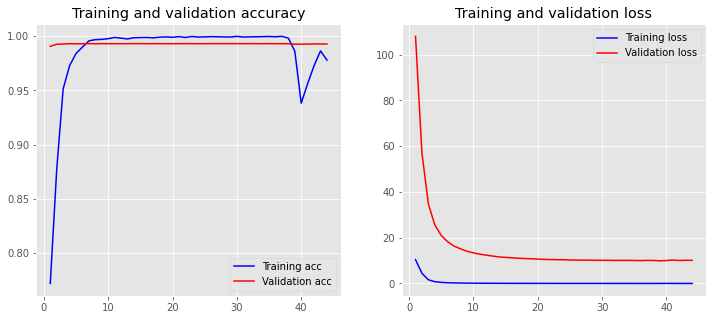

864/864 [==============================] - 72s 79ms/step
F1-score: 42.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.45420699925539837,0.4374153453908055,0.4456530562545661,12551.0
test,0.39499600745275487,0.4940079893475366,0.4389883153379678,9012.0
treatment,0.42543584598018314,0.36406568637973596,0.3923655292076345,9317.0
micro avg,0.425584883980722,0.43180051813471504,0.4286701708701034,30880.0
macro avg,0.42487961756277876,0.43182967370602604,0.42566896693338946,30880.0
weighted avg,0.42824617369870777,0.43180051813471504,0.4276303057805814,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10391 words (18064 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          2845500   
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,007,756
Trainable params: 3,007,756
Non-trainable

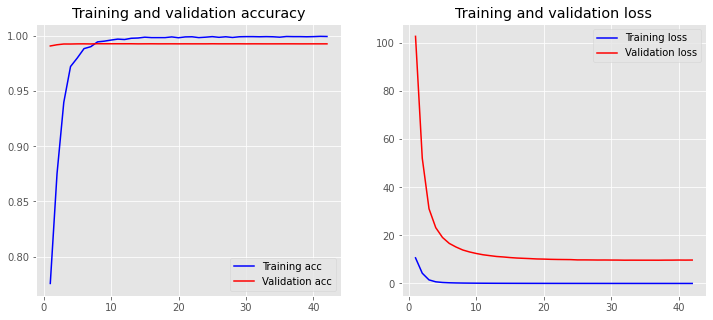

864/864 [==============================] - 70s 77ms/step
F1-score: 46.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.46689059500959695,0.4651422197434467,0.46601476751147475,12551.0
test,0.540063492063492,0.47192632046160676,0.5037010718304021,9012.0
treatment,0.47186327636515213,0.3644950091231083,0.41128739251544144,9317.0
micro avg,0.489084711343197,0.43675518134715025,0.46144108389215815,30880.0
macro avg,0.49293912114608035,0.4338545164427206,0.4603344106191061,30880.0
weighted avg,0.48974566691501825,0.43675518134715025,0.4605009728768935,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Converted 10402 words (18057 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          2845900   
                                                                 
 bidirectional_2 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,008,156
Trainable params: 3,008,156
Non-trainable

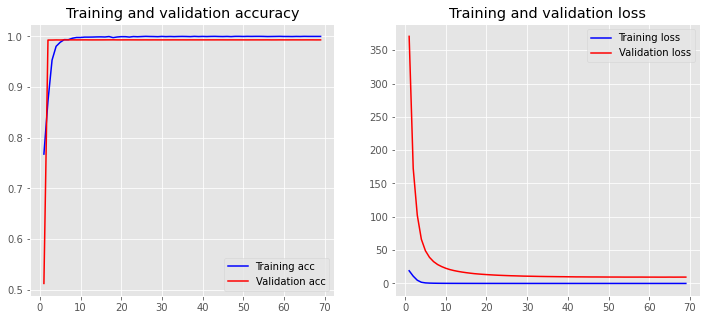

864/864 [==============================] - 71s 78ms/step
F1-score: 47.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.4699405240315062,0.465859294080153,0.46789100948265516,12551.0
test,0.5377940168988353,0.5226364846870839,0.530106921778278,9012.0
treatment,0.48644623175454277,0.3505420199635076,0.4074605451936873,9317.0
micro avg,0.4951995414487354,0.4476360103626943,0.47021804946082935,30880.0
macro avg,0.49806025756162814,0.44634593291024816,0.4684861588182068,30880.0
weighted avg,0.49472288661492264,0.4476360103626943,0.4678152052672354,30880.0



In [13]:
number_of_training_models = 3
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10390 words (18065 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          2845500   
                                                                 
 bidirectional_3 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,007,756
Trainable params: 3,007,756
Non-trainab

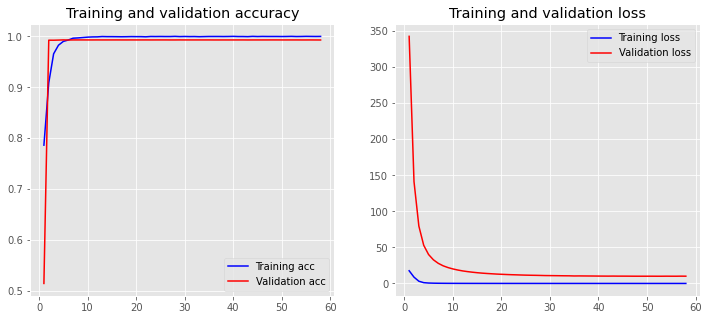

864/864 [==============================] - 71s 78ms/step
F1-score: 45.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.44275582573454914,0.4526332563142379,0.44764005988495786,12551.0
test,0.5428640425018112,0.49889036839769196,0.5199491153001041,9012.0
treatment,0.47035206917850525,0.3269292690780294,0.3857405179509909,9317.0
micro avg,0.4792852223712349,0.4282059585492228,0.4523080606817288,30880.0
macro avg,0.48532397913828856,0.4261509645966531,0.45110989771201765,30880.0
weighted avg,0.48029758252450716,0.4282059585492228,0.4500665875793402,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10398 words (18077 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          2847500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,009,756
Trainable params: 3,009,756
Non-trainab

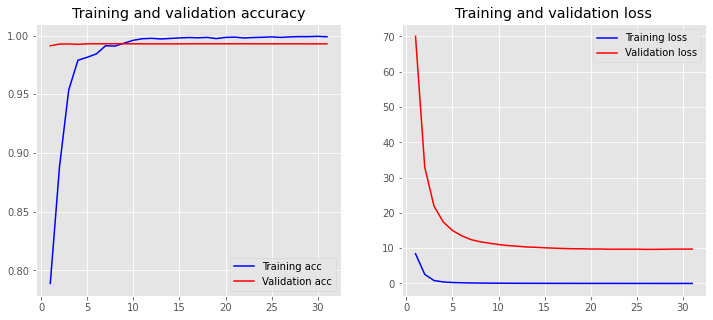

864/864 [==============================] - 70s 77ms/step
F1-score: 48.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.48145706279874734,0.46546091944864953,0.4733238808993316,12551.0
test,0.5671965317919075,0.5226364846870839,0.5440055440055439,9012.0
treatment,0.48634243837441704,0.3917570033272513,0.433955534419213,9317.0
micro avg,0.5082489353326415,0.4599093264248705,0.48287234585111266,30880.0
macro avg,0.5116653443216906,0.4599514691543282,0.4837616531080295,30880.0
weighted avg,0.5079532136667809,0.4599093264248705,0.48207350083967876,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10406 words (18060 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 204, 100)          2846600   
                                                                 
 bidirectional_5 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,008,856
Trainable params: 3,008,856
Non-trainab

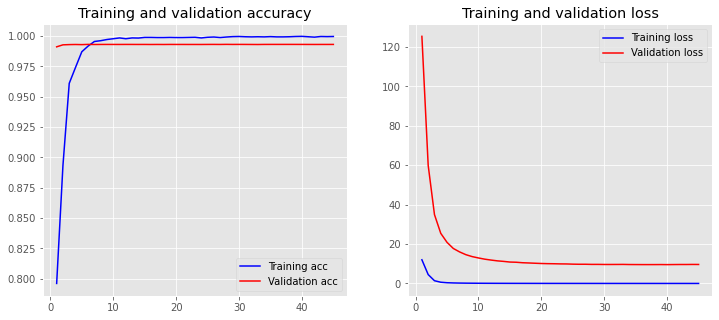

864/864 [==============================] - 71s 78ms/step
F1-score: 47.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.47538996201406286,0.4686479165006772,0.47199486438773874,12551.0
test,0.5575699363669108,0.5153129161118508,0.535609249754916,9012.0
treatment,0.47007920211205634,0.34399484812707953,0.39727300898667495,9317.0
micro avg,0.49894622093023255,0.44465673575129533,0.4702397260273973,30880.0
macro avg,0.5010130334976767,0.44265189357986917,0.46829237437644317,30880.0
weighted avg,0.49777097169219986,0.44465673575129533,0.46801524373221054,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10405 words (18074 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 204, 100)          2847900   
                                                                 
 bidirectional_6 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,010,156
Trainable params: 3,010,156
Non-trainab

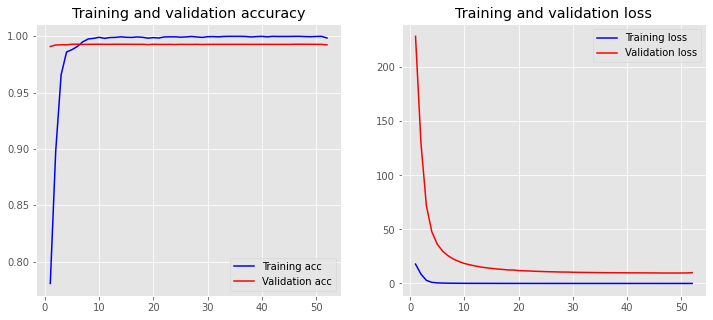

864/864 [==============================] - 73s 81ms/step
F1-score: 45.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.46888,0.4669747430483627,0.4679254321184783,12551.0
test,0.5601036976395143,0.45550377274744785,0.5024172327274953,9012.0
treatment,0.4513736263736264,0.35268863368036923,0.3959751762366693,9317.0
micro avg,0.4888413442030322,0.42914507772020727,0.4570521995550881,30880.0
macro avg,0.49345244133771354,0.4250557164920599,0.45543928036088094,30880.0
weighted avg,0.4902207085508543,0.42914507772020727,0.45628293124534514,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10416 words (18070 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 204, 100)          2848600   
                                                                 
 bidirectional_7 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,010,856
Trainable params: 3,010,856
Non-trainab

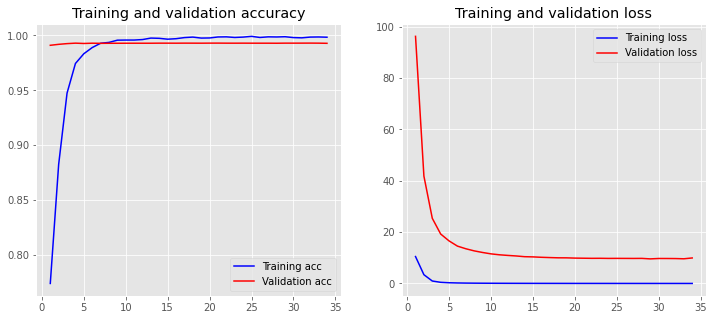

864/864 [==============================] - 73s 81ms/step
F1-score: 46.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.45838016033565593,0.48745119910764084,0.4724689165186501,12551.0
test,0.5199858923113096,0.49079005770084333,0.504966320356205,9012.0
treatment,0.4494150034411562,0.35043468927766447,0.39380050657339283,9317.0
micro avg,0.47413970739748607,0.4470854922279793,0.4602153405113504,30880.0
macro avg,0.47592701869604054,0.4428919820287162,0.45707858114941596,30880.0
weighted avg,0.4736542046937692,0.4470854922279793,0.458217395402202,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10404 words (18075 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 204, 100)          2847900   
                                                                 
 bidirectional_8 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,010,156
Trainable params: 3,010,156
Non-trainab

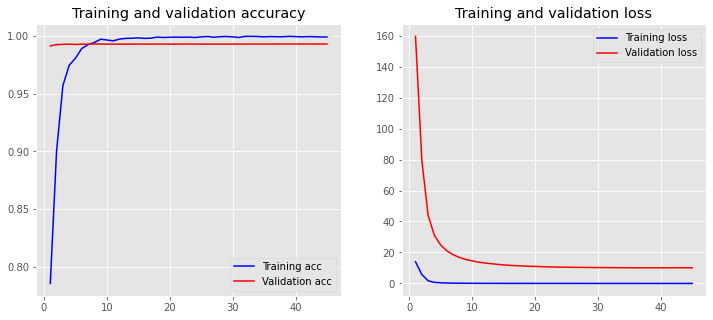

864/864 [==============================] - 72s 80ms/step
F1-score: 46.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.46991290577988915,0.472870687594614,0.4713871569834399,12551.0
test,0.5387462686567164,0.5006657789613849,0.5190084545925117,9012.0
treatment,0.4746619111309258,0.34281421058280565,0.39810544684033405,9317.0
micro avg,0.4918511574241004,0.4417422279792746,0.4654519398096018,30880.0
macro avg,0.4944403618558438,0.43878355904626815,0.46283368613876186,30880.0
weighted avg,0.49143404402799723,0.4417422279792746,0.46317463886976235,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10411 words (18066 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 204, 100)          2847700   
                                                                 
 bidirectional_9 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,009,956
Trainable params: 3,009,956
Non-trainab

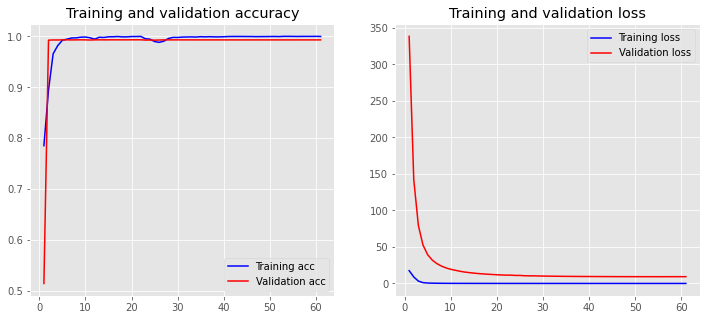

864/864 [==============================] - 74s 82ms/step
F1-score: 46.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.49525277935567635,0.4862560752131304,0.49071319450028145,12551.0
test,0.5502189381499726,0.44618286728806034,0.4927696078431372,9012.0
treatment,0.4899743705713855,0.34882472899001826,0.40752351097178685,9317.0
micro avg,0.5092141334145599,0.4330958549222798,0.46808063838723224,30880.0
macro avg,0.5118153626923448,0.42708789049706963,0.4636687711050685,30880.0
weighted avg,0.509701486881938,0.4330958549222798,0.46621365161203115,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10398 words (18071 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 204, 100)          2846900   
                                                                 
 bidirectional_10 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,009,156
Trainable params: 3,009,156
Non-traina

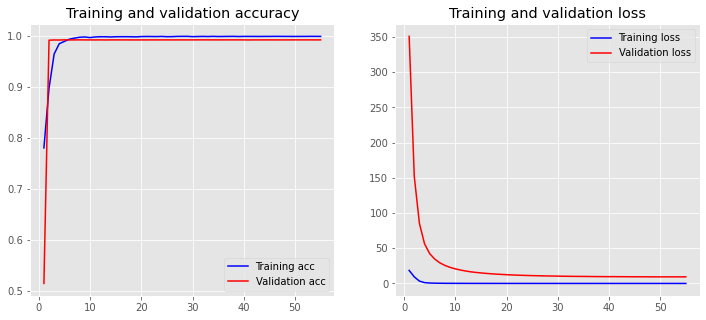

864/864 [==============================] - 72s 80ms/step
F1-score: 44.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.45527043031977893,0.4594056250497968,0.4573286802030457,12551.0
test,0.5295404814004376,0.4565024411895251,0.49031642929503605,9012.0
treatment,0.4444597764592245,0.34571213910056886,0.38891572084037673,9317.0
micro avg,0.47328492467757666,0.42425518134715023,0.44743088403545017,30880.0
macro avg,0.4764235627264804,0.4205400684466303,0.44552027677948614,30880.0
weighted avg,0.4736836051358446,0.42425518134715023,0.44631449796324746,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10402 words (18072 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 204, 100)          2847400   
                                                                 
 bidirectional_11 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,009,656
Trainable params: 3,009,656
Non-traina

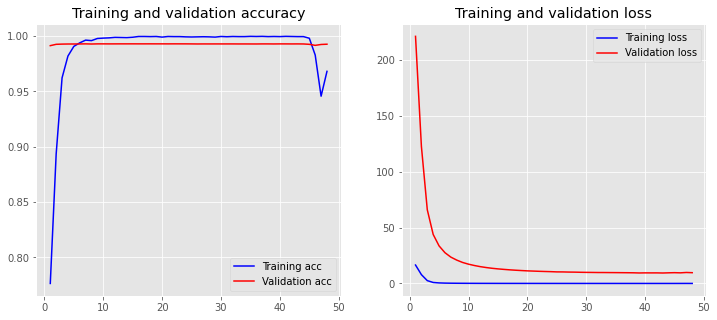

864/864 [==============================] - 71s 78ms/step
F1-score: 46.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.4672316384180791,0.4612381483547128,0.46421554869492004,12551.0
test,0.5158876352751555,0.4972259209942299,0.5063849022488417,9012.0
treatment,0.43886728245017015,0.38757110657937105,0.4116272442291251,9317.0
micro avg,0.4736895986895987,0.4495142487046632,0.4612853914661705,30880.0
macro avg,0.4739955187144682,0.4486783919761046,0.46074256505762895,30880.0
weighted avg,0.4728733851513357,0.4495142487046632,0.4606554768529553,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Converted 10411 words (18071 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 204, 100)          2848200   
                                                                 
 bidirectional_12 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,010,456
Trainable params: 3,010,456
Non-traina

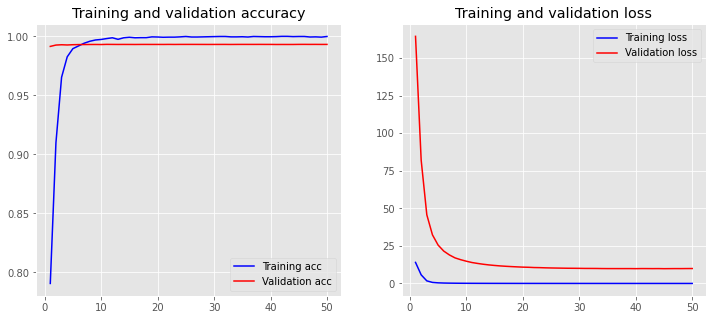

864/864 [==============================] - 74s 82ms/step
F1-score: 46.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.46651251793972254,0.46617799378535574,0.46634519587135853,12551.0
test,0.5042889390519187,0.4957833999112295,0.5,9012.0
treatment,0.49155313351498636,0.3872491145218418,0.4332112625322687,9317.0
micro avg,0.4845522232273328,0.4510038860103627,0.467176545570427,30880.0
macro avg,0.4874515301688758,0.44973683607280895,0.4665188194678757,30880.0
weighted avg,0.4850923276022175,0.4510038860103627,0.4661699445075961,30880.0



In [14]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10443 words (18086 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 204, 100)          2852900   
                                                                 
 bidirectional_13 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,015,156
Trainable params: 3,015,156
Non-traina

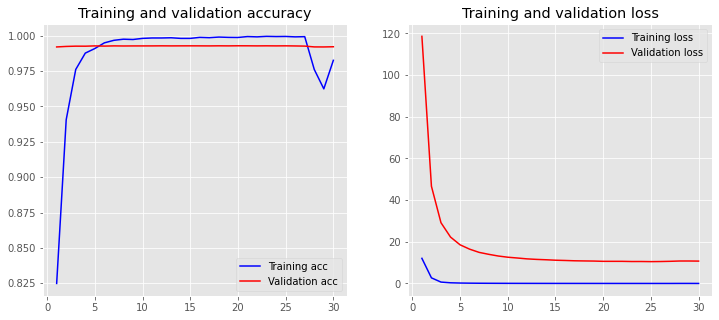

864/864 [==============================] - 70s 77ms/step
F1-score: 43.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.45504865636996694,0.4061030993546331,0.4291849107443584,12551.0
test,0.5025415896487985,0.4826897470039947,0.49241566674213266,9012.0
treatment,0.4291096846218253,0.3300418589674788,0.37311169083297935,9317.0
micro avg,0.46338304407356695,0.40550518134715025,0.43251644992487437,30880.0
macro avg,0.46223331021353026,0.4062782351087022,0.4315707561064901,30880.0
weighted avg,0.4610827533560872,0.40550518134715025,0.43071992962834876,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10440 words (18087 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 204, 100)          2852700   
                                                                 
 bidirectional_14 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,014,956
Trainable params: 3,014,956
Non-traina

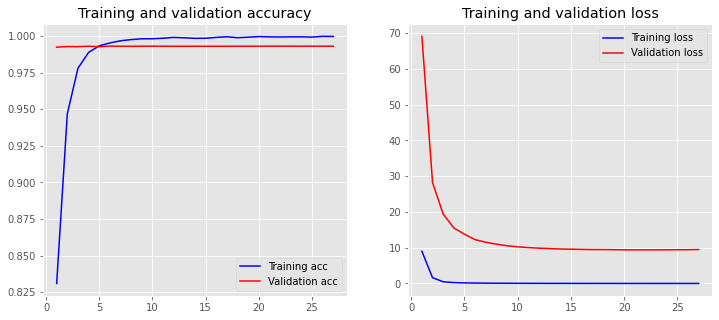

864/864 [==============================] - 74s 81ms/step
F1-score: 45.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.47934027777777777,0.43996494303242767,0.45880935565618375,12551.0
test,0.5856187747305226,0.47625388371060806,0.5253044489321339,9012.0
treatment,0.5060007059654077,0.30771707631211764,0.3827003937796169,9317.0
micro avg,0.5172751376708138,0.4106541450777202,0.45783915515840784,30880.0
macro avg,0.5236532528245693,0.4079786343517178,0.4556047327893115,30880.0
weighted avg,0.5184004145641212,0.4106541450777202,0.45525192634267625,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10434 words (18085 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 204, 100)          2851900   
                                                                 
 bidirectional_15 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,014,156
Trainable params: 3,014,156
Non-traina

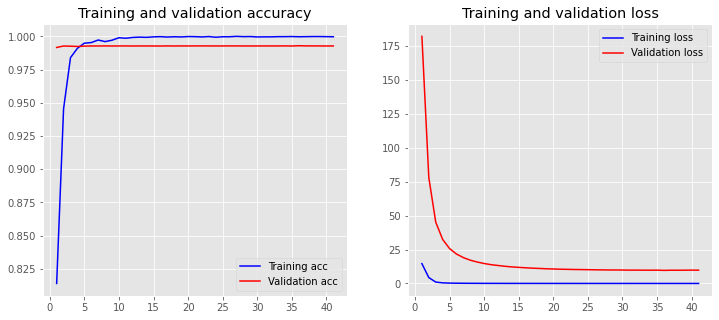

864/864 [==============================] - 74s 82ms/step
F1-score: 45.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.45824325406357597,0.45597960321886705,0.4571086261980831,12551.0
test,0.5471009935857125,0.4826897470039947,0.51288097624241,9012.0
treatment,0.45837202104611574,0.3179134914672105,0.3754357056847709,9317.0
micro avg,0.48453646569028325,0.4221178756476684,0.4511785677200512,30880.0
macro avg,0.48790542289846806,0.41886094723002404,0.44847510270842134,30880.0
weighted avg,0.4842142926176504,0.4221178756476684,0.4487431410354194,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10434 words (18090 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 204, 100)          2852400   
                                                                 
 bidirectional_16 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,014,656
Trainable params: 3,014,656
Non-traina

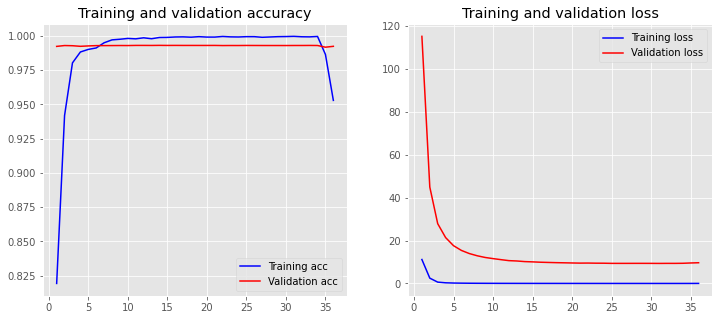

864/864 [==============================] - 72s 80ms/step
F1-score: 46.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.4817582417582418,0.4366185961277986,0.45807907715455987,12551.0
test,0.5390358091863849,0.47270306258322237,0.5036949453148093,9012.0
treatment,0.5171704383605,0.3507566813351937,0.4180097211563059,9317.0
micro avg,0.5081845528772903,0.4212435233160622,0.4606476972927032,30880.0
macro avg,0.5126548297683756,0.4200261133487382,0.4599279145418917,30880.0
weighted avg,0.5091585291094616,0.4212435233160622,0.4593020050698589,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10441 words (18080 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 204, 100)          2852100   
                                                                 
 bidirectional_17 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,014,356
Trainable params: 3,014,356
Non-traina

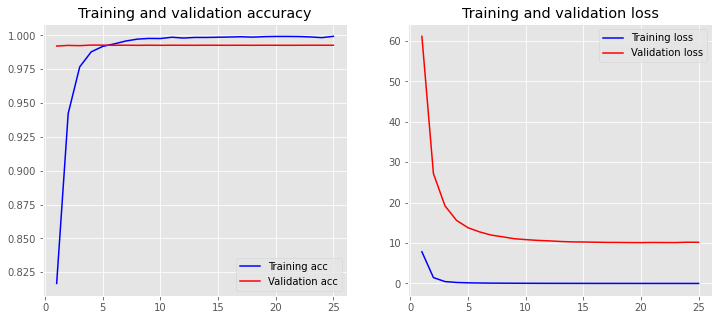

864/864 [==============================] - 75s 82ms/step
F1-score: 45.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.45861076120208744,0.4061030993546331,0.4307627297697021,12551.0
test,0.5711533521705625,0.49345317354638263,0.5294677937849744,9012.0
treatment,0.4801987886317751,0.3318664806268112,0.39248540238639246,9317.0
micro avg,0.49867792730573424,0.4091968911917098,0.449527739732119,30880.0
macro avg,0.5033209673348084,0.41047425117594233,0.450905308647023,30880.0
weighted avg,0.49796858119464893,0.4091968911917098,0.44801985987576876,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10427 words (18088 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 204, 100)          2851500   
                                                                 
 bidirectional_18 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,013,756
Trainable params: 3,013,756
Non-traina

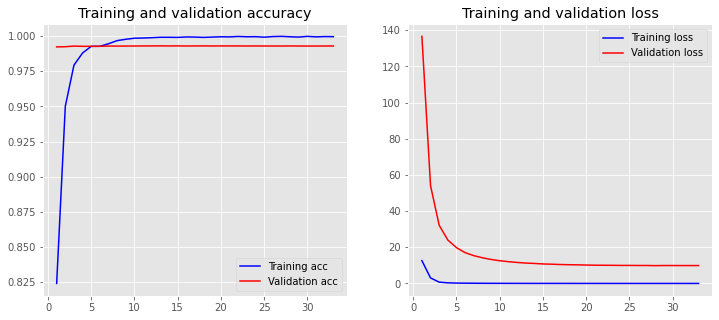

864/864 [==============================] - 70s 77ms/step
F1-score: 44.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.4680703578546053,0.4304039518763445,0.4484476174663789,12551.0
test,0.5047169811320755,0.43930315135375053,0.4697437114380636,9012.0
treatment,0.49978333092589916,0.3713641730170656,0.42610837438423643,9317.0
micro avg,0.4873422533069789,0.4151878238341969,0.4483807791844443,30880.0
macro avg,0.49085688997086,0.41369042541572015,0.4480999010962263,30880.0
weighted avg,0.48833360717720264,0.4151878238341969,0.44792254204787185,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10441 words (18082 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 204, 100)          2852300   
                                                                 
 bidirectional_19 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,014,556
Trainable params: 3,014,556
Non-traina

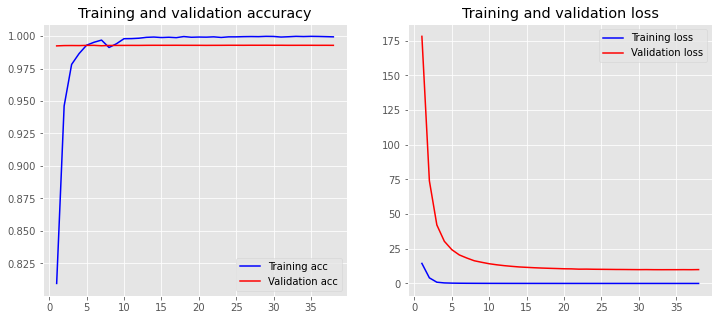

864/864 [==============================] - 72s 79ms/step
F1-score: 45.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.4679226069246436,0.43932754362202214,0.453174440106842,12551.0
test,0.5325596389426177,0.45827785175321795,0.4926343412655812,9012.0
treatment,0.5137675185490519,0.3344424170870452,0.4051488753088025,9317.0
micro avg,0.4983596313076082,0.41321243523316065,0.45180936194320515,30880.0
macro avg,0.5047499214721044,0.41068260415409513,0.4503192188937419,30880.0
weighted avg,0.5006183962429918,0.41321243523316065,0.45020029638984793,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10440 words (18088 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 204, 100)          2852800   
                                                                 
 bidirectional_20 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,015,056
Trainable params: 3,015,056
Non-traina

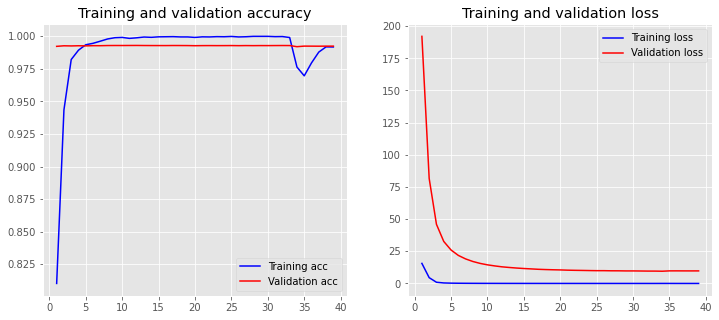

864/864 [==============================] - 76s 84ms/step
F1-score: 37.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.425259659326963,0.40777627280694767,0.4163344993085496,12551.0
test,0.3666106553326085,0.41156236129604973,0.38778817502221763,9012.0
treatment,0.34540389972144847,0.2661801008908447,0.30066072619264106,9317.0
micro avg,0.3854834310650484,0.3661593264248705,0.3755729754866139,30880.0
macro avg,0.37909140479367337,0.36183957833128066,0.36826113350780276,30880.0
weighted avg,0.38404978444866955,0.3661593264248705,0.37310289248894646,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10444 words (18107 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 204, 100)          2855100   
                                                                 
 bidirectional_21 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,017,356
Trainable params: 3,017,356
Non-traina

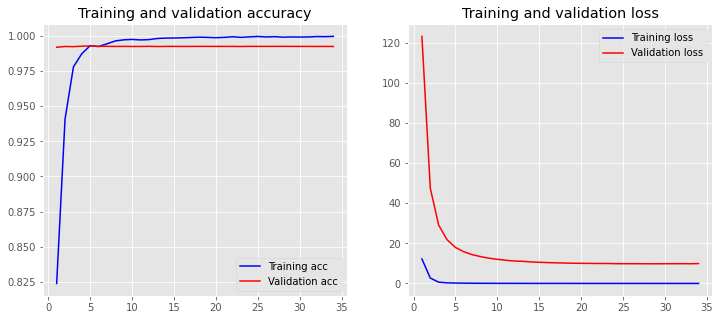

864/864 [==============================] - 73s 81ms/step
F1-score: 43.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.4654790392626075,0.41845271293124053,0.4407149450365025,12551.0
test,0.5257958287596048,0.42521083000443854,0.47018404907975464,9012.0
treatment,0.4744846231835079,0.3013845658473758,0.368624876928126,9317.0
micro avg,0.4856057821879211,0.3851036269430052,0.42955444382235547,30880.0
macro avg,0.48858649706857343,0.38168270292768497,0.4265079570147943,30880.0
weighted avg,0.485798985258008,0.3851036269430052,0.4275644398898718,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 10440 words (18091 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 204, 100)          2853100   
                                                                 
 bidirectional_22 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,015,356
Trainable params: 3,015,356
Non-traina

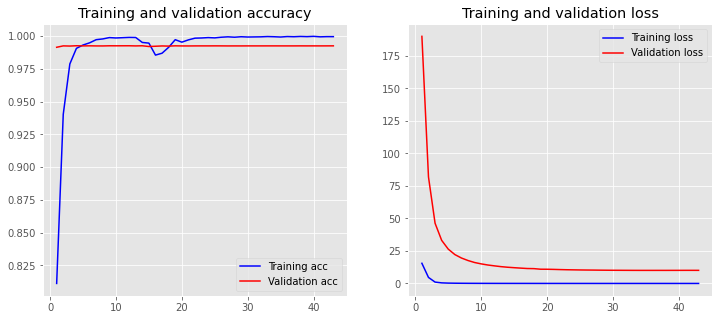

864/864 [==============================] - 74s 81ms/step
F1-score: 43.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.4448464450988641,0.4212413353517648,0.43272221312817155,12551.0
test,0.5383272922539938,0.4449622725255215,0.4872121985298584,9012.0
treatment,0.5242400923432089,0.29247611892239994,0.37547364795039617,9317.0
micro avg,0.4900538072721344,0.38931347150259066,0.43391323179094776,30880.0
macro avg,0.5024712765653556,0.3862265755998954,0.431802686536142,30880.0
weighted avg,0.4960821965864803,0.38931347150259066,0.43135171010610773,30880.0



In [15]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10516 words (18140 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 204, 100)          2865600   
                                                                 
 bidirectional_23 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,027,856
Trainable params: 3,027,856
Non-traina

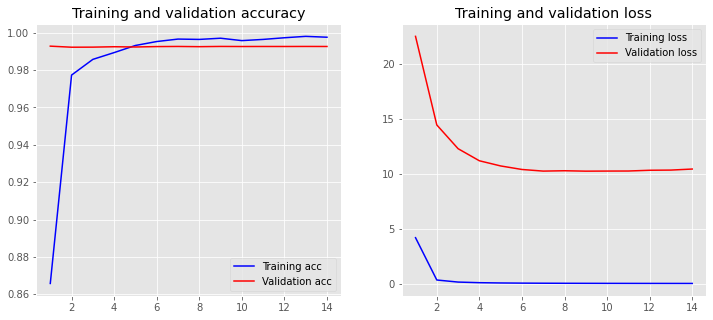

864/864 [==============================] - 72s 80ms/step
F1-score: 43.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.4982004580652198,0.3639550633415664,0.42062615101289136,12551.0
test,0.567957590929171,0.42798490901020864,0.4881351642093274,9012.0
treatment,0.527009705182201,0.30889771385639153,0.3894979022871837,9317.0
micro avg,0.5276597731198357,0.36602979274611397,0.4322288292766869,30880.0
macro avg,0.5310559180588639,0.3669458954027222,0.4327530725031341,30880.0
weighted avg,0.5272505564058558,0.36602979274611397,0.4309360387573493,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10526 words (18131 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 204, 100)          2865700   
                                                                 
 bidirectional_24 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,027,956
Trainable params: 3,027,956
Non-traina

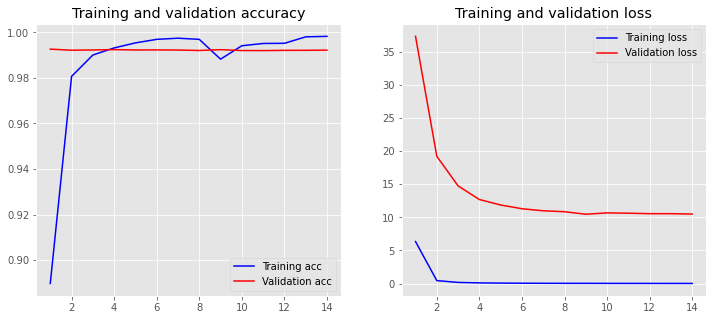

864/864 [==============================] - 72s 79ms/step
F1-score: 39.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.46593803056027167,0.3498526013863437,0.3996359499431172,12551.0
test,0.5079710144927536,0.3889258766089658,0.44054801407742583,9012.0
treatment,0.433179012345679,0.3012772351615327,0.3553839336582896,9317.0
micro avg,0.46934748289773726,0.3465997409326425,0.3987407793756054,30880.0
macro avg,0.4690293524662348,0.3466852377189474,0.3985226325596109,30880.0
weighted avg,0.46832097999337297,0.3465997409326425,0.39822414574145426,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10530 words (18130 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 204, 100)          2866000   
                                                                 
 bidirectional_25 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,028,256
Trainable params: 3,028,256
Non-traina

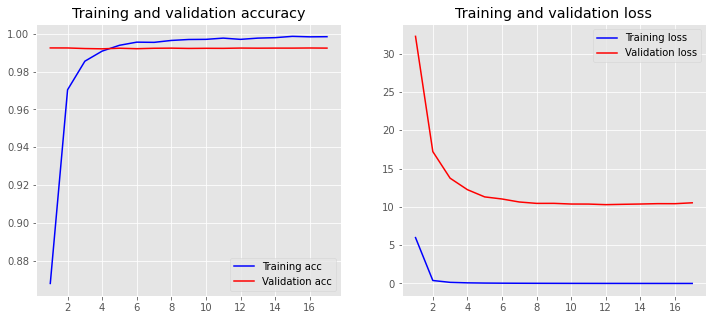

864/864 [==============================] - 73s 80ms/step
F1-score: 40.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.4549301735082522,0.34260218309298063,0.3908557923919465,12551.0
test,0.5484960098219767,0.39658233466489123,0.4603297269448738,9012.0
treatment,0.5035765379113019,0.3022432113341204,0.37775840096585955,9317.0
micro avg,0.4958256029684601,0.34617875647668395,0.4077040427154844,30880.0
macro avg,0.5023342404138437,0.3471425763639974,0.40964797343422665,30880.0
weighted avg,0.49691377111196006,0.34617875647668395,0.4071793254966786,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10536 words (18125 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 204, 100)          2866100   
                                                                 
 bidirectional_26 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,028,356
Trainable params: 3,028,356
Non-traina

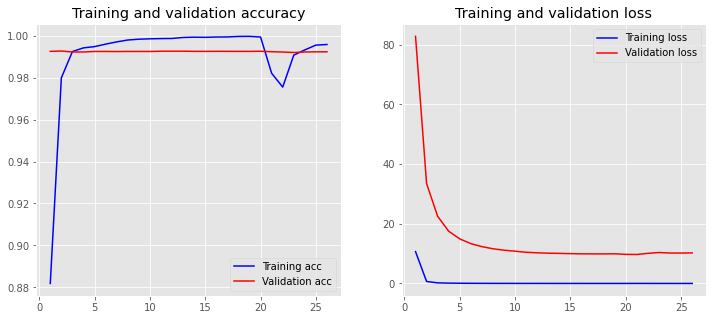

864/864 [==============================] - 72s 80ms/step
F1-score: 38.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.4373792376602846,0.396781132977452,0.416092242135606,12551.0
test,0.4264894485251253,0.40590324012427875,0.41594178179544034,9012.0
treatment,0.4171539961013645,0.2526564344746163,0.31470588235294117,9317.0
micro avg,0.4292743888151215,0.3559585492227979,0.38919378253018444,30880.0
macro avg,0.4270075607622581,0.3517802691921157,0.38224663542799586,30880.0
weighted avg,0.42809888289051407,0.3559585492227979,0.3854584123855846,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10524 words (18132 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 204, 100)          2865600   
                                                                 
 bidirectional_27 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,027,856
Trainable params: 3,027,856
Non-traina

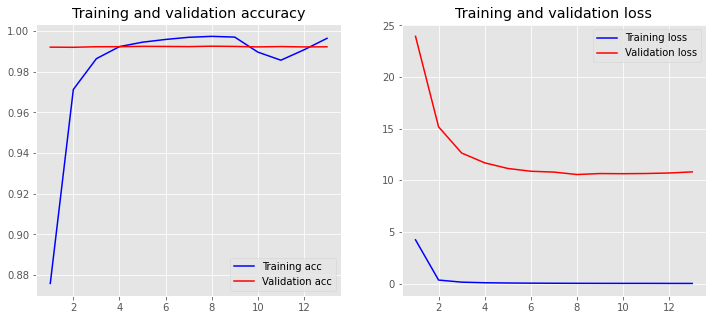

864/864 [==============================] - 70s 78ms/step
F1-score: 39.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.43676484883833966,0.3579794438690144,0.39346702863648314,12551.0
test,0.4759583717560269,0.4009098979138926,0.4352225501415407,9012.0
treatment,0.49512743628185907,0.28356767199742405,0.3606087490616256,9317.0
micro avg,0.4629964676488326,0.3480569948186529,0.39738233445483795,30880.0
macro avg,0.46928355229207525,0.3474856712601104,0.3964327759465498,30880.0
weighted avg,0.4658120073793199,0.3480569948186529,0.39573905483481964,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10525 words (18137 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 204, 100)          2866200   
                                                                 
 bidirectional_28 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,028,456
Trainable params: 3,028,456
Non-traina

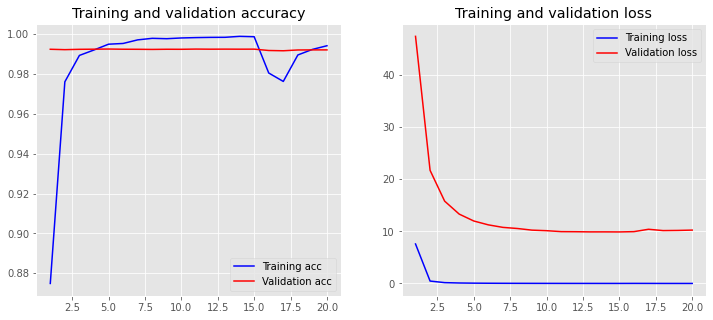

864/864 [==============================] - 75s 83ms/step
F1-score: 41.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.4689403166869671,0.3374233128834356,0.3924566768603466,12551.0
test,0.5794780545670225,0.43364403018197956,0.49606499111449603,9012.0
treatment,0.47194844579226686,0.26725340774927553,0.3412595079832797,9317.0
micro avg,0.5051066457650468,0.34433290155440416,0.4095049199899868,30880.0
macro avg,0.5067889390154189,0.3461069169382302,0.40992705865270745,30880.0
weighted avg,0.5021071830292319,0.34433290155440416,0.40724664142092826,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10534 words (18134 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 204, 100)          2866800   
                                                                 
 bidirectional_29 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,029,056
Trainable params: 3,029,056
Non-traina

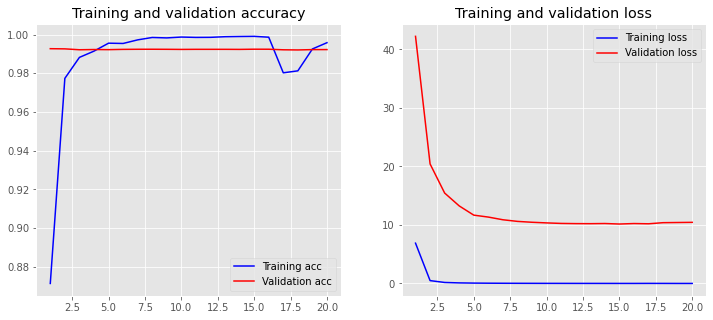

864/864 [==============================] - 72s 79ms/step
F1-score: 40.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.4594303611627679,0.37399410405545375,0.41233309908643706,12551.0
test,0.5229893664819529,0.38748335552596536,0.4451526547262413,9012.0
treatment,0.4248024830699774,0.32317269507352153,0.3670832063395307,9317.0
micro avg,0.46689183554332414,0.36259715025906736,0.40818781670372933,30880.0
macro avg,0.4690740702382328,0.36155005155164693,0.40818965338406965,30880.0
weighted avg,0.4675315857659404,0.36259715025906736,0.4082585066221556,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10541 words (18134 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 204, 100)          2867500   
                                                                 
 bidirectional_30 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,029,756
Trainable params: 3,029,756
Non-traina

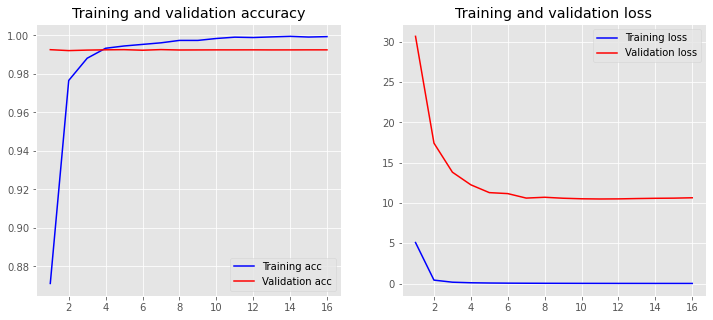

864/864 [==============================] - 74s 82ms/step
F1-score: 42.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.4413075780089153,0.3549517966695881,0.3934469663516736,12551.0
test,0.5709557850145618,0.4785841100754549,0.5207050585536641,9012.0
treatment,0.473349099508823,0.27927444456370076,0.3512893209126502,9317.0
micro avg,0.4912295861055906,0.36819948186528495,0.4209084514863214,30880.0
macro avg,0.4952041541774333,0.3709367837695812,0.4218137819393293,30880.0
weighted avg,0.4888114801251564,0.36819948186528495,0.41786623916154914,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10520 words (18118 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 204, 100)          2863800   
                                                                 
 bidirectional_31 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,026,056
Trainable params: 3,026,056
Non-traina

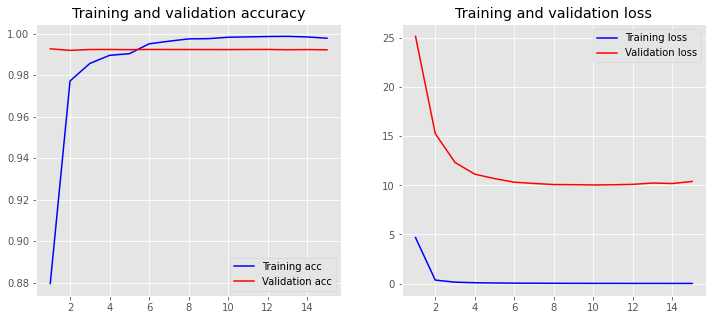

864/864 [==============================] - 70s 77ms/step
F1-score: 40.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.47739463601532567,0.3474623535973229,0.40219496449322145,12551.0
test,0.5363889295650901,0.40645805592543277,0.46247080361088316,9012.0
treatment,0.5011015421590226,0.2685413759793925,0.34968553459119495,9317.0
micro avg,0.5022665457842248,0.3408678756476684,0.4061191812797808,30880.0
macro avg,0.5049617025798128,0.34082059516738267,0.4047837675650998,30880.0
weighted avg,0.5017642544742409,0.3408678756476684,0.40394287588348005,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 10521 words (18123 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 204, 100)          2864400   
                                                                 
 bidirectional_32 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,026,656
Trainable params: 3,026,656
Non-traina

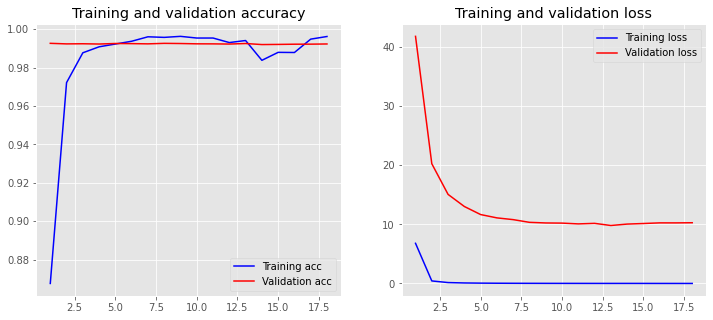

864/864 [==============================] - 73s 80ms/step
F1-score: 41.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.44738963918564806,0.353676997848777,0.39505183998576066,12551.0
test,0.5292393579902303,0.4207723035952064,0.46881374791370467,9012.0
treatment,0.3873827965756217,0.40796393688955673,0.3974070782581421,9317.0
micro avg,0.44730287371277744,0.38963730569948185,0.41648349746447666,30880.0
macro avg,0.45467059791716674,0.3941377461111801,0.4204242220525358,30880.0
weighted avg,0.4531715664288242,0.38963730569948185,0.41728908316032054,30880.0



In [16]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)